In [204]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [205]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'spielberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/',
        'scorsese': 'https://www.imdb.com/name/nm0000217/'}
        # scorcese

dirs_box_office = {'godard':'https://www.the-numbers.com/person/55430401-Jean-Luc-Godard#tab=technical', \
                   'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical', \
                   'spielberg': 'https://www.the-numbers.com/person/135430401-Steven-Spielberg#tab=technical',\
                   'allen':'https://www.the-numbers.com/person/4010401-Woody-Allen#tab=technical', \
                   'bergman': 'https://www.the-numbers.com/person/13600401-Ingmar-Bergman#tab=technical',\
                   'herzog':'https://www.the-numbers.com/person/65080401-Werner-Herzog#tab=technical',
                   'scorsese': 'https://www.the-numbers.com/person/128910401-Martin-Scorsese#tab=technical'}

In [206]:
director = 'hitchcock'

In [207]:

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [208]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [209]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [210]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [211]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
  #     the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

In [212]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [213]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [214]:
list_of_films = []
dict_of_all_actors = {}

index_ = 0 # temporary for record keeping
for film in films:
    cast_dict = {}
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    cast_dict = parse_cast_data(film_soup)
    film_record.update( cast_dict )
    dict_of_all_actors.update( cast_dict )
    #dict_of_all_actors = parse_cast_data(film_soup)
   
    print(index_) # temporary for record keeping
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt6914094/
0
{'title': 'Kaleidoscope', 'year': '1967', 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Arthur Schatz'}

 https://imdb.com/title/tt3455796/
1
{'title': 'Memory of the Camps', 'year': '2014', 'rating': '8.3', 'rating_count': 481.0, 'duration': 70, 'release_date': ' 26 July 2015 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 4468, 'runtime': 70, 'budget': None, 'tv_series': 1, 'documentary': 1, 'cinematographer': '', 'Jasper Britton': 1, 'Adolf Hitler': 1}

 https://imdb.com/title/tt0074512/
2
{'title': 'Family Plot', 'year': '1976', 'rating': '6.8', 'rating_count': 20794.0, 'duration': None, 'release_date': ' 9 April 1976 (USA)    ', 'metacritic_score': '79', 'worldwide_gross_imdb': None, 'runtime': 120, 'budget': 4490375, 'tv_series': 0, 'documentary': 0, 'cinemat

15
{'title': 'The Wrong Man', 'year': '1956', 'rating': '7.4', 'rating_count': 25655.0, 'duration': 105, 'release_date': ' 26 January 1957 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 105, 'budget': 1200000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Robert Burks', 'Henry Fonda': 1, 'Vera Miles': 1, 'Anthony Quayle': 1, 'Harold J. Stone': 1, 'Charles Cooper': 1, 'John Heldabrand': 1, 'Esther Minciotti': 1, 'Doreen Lang': 1, 'Laurinda Barrett': 1, 'Norma Connolly': 1, 'Nehemiah Persoff': 1, "Lola D'Annunzio": 1, 'Kippy Campbell': 1, 'Robert Essen': 1, 'Richard Robbins': 1}

 https://imdb.com/title/tt0049470/
16
{'title': 'The Man Who Knew Too Much', 'year': '1956', 'rating': '7.4', 'rating_count': 58462.0, 'duration': None, 'release_date': ' 1 June 1956 (USA)    ', 'metacritic_score': '78', 'worldwide_gross_imdb': 8190, 'runtime': 120, 'budget': 2500000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Robert Burks', 'James Stewart': 1, 

29
{'title': 'Watchtower Over Tomorrow', 'year': '1945', 'rating': '6.5', 'rating_count': 213.0, 'duration': 15, 'release_date': ' 29 March 1945 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 15, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Lester White', 'John Nesbitt': 1, 'Edward R. Stettinius Jr.': 1}

 https://imdb.com/title/tt1375299/
30
{'title': 'The Fighting Generation', 'year': '1944', 'rating': '5.9', 'rating_count': 213.0, 'duration': 2, 'release_date': ' October 1944 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 2, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Gregg Toland', 'Jennifer Jones': 1, 'Rhonda Fleming': 1, 'Steve Dunhill': 1, 'Tony Devlin': 1}

 https://imdb.com/title/tt0036621/
31
{'title': 'Aventure malgache', 'year': '1944', 'rating': '5.5', 'rating_count': 1448.0, 'duration': 32, 'release_date': ' June 1944 (Portugal)    ', 'metacritic_score': None

44
{'title': 'Sabotage', 'year': '1936', 'rating': '7.0', 'rating_count': 14941.0, 'duration': 76, 'release_date': ' 11 January 1937 (USA)    ', 'metacritic_score': '85', 'worldwide_gross_imdb': None, 'runtime': 76, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Bernard Knowles', 'Sylvia Sidney': 1, 'Oskar Homolka': 1, 'Desmond Tester': 1, 'John Loder': 1, 'Joyce Barbour': 1, 'Matthew Boulton': 1, 'S.J. Warmington': 1, 'William Dewhurst': 1}

 https://imdb.com/title/tt0028231/
45
{'title': 'Secret Agent', 'year': '1936', 'rating': '6.5', 'rating_count': 7767.0, 'duration': 86, 'release_date': ' 15 June 1936 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 86, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Bernard Knowles', 'Madeleine Carroll': 1, 'Peter Lorre': 1, 'John Gielgud': 1, 'Robert Young': 1, 'Percy Marmont': 1, 'Florence Kahn': 1, 'Charles Carson': 1, 'Lilli Palmer': 1}

 https://imdb.com/title/tt0026

60
{'title': 'The Manxman', 'year': '1929', 'rating': '6.2', 'rating_count': 2603.0, 'duration': 110, 'release_date': ' 16 December 1929 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 110, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Jack E. Cox', 'Carl Brisson': 1, 'Malcolm Keen': 1, 'Anny Ondra': 1, 'Randle Ayrton': 1, 'Clare Greet': 1}

 https://imdb.com/title/tt0018756/
61
{'title': 'Champagne', 'year': '1928', 'rating': '5.6', 'rating_count': 2025.0, 'duration': 86, 'release_date': ' 20 August 1928 (UK)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 86, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Jack E. Cox', 'Betty Balfour': 1, 'Jean Bradin': 1, 'Ferdinand von Alten': 1, 'Gordon Harker': 1}

 https://imdb.com/title/tt0018876/
62
{'title': "The Farmer's Wife", 'year': '1928', 'rating': '5.9', 'rating_count': 2496.0, 'duration': 129, 'release_date': ' 4 January 1930 (USA)  

In [215]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [216]:
len(film_catalog.columns)

646

In [217]:
len(dict_of_all_actors)

633

In [218]:
len(film_catalog.columns) - len(dict_of_all_actors)

13

In [219]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [220]:
main_column_names = list(film_catalog.columns[:first_cast_column])
main_column_names 

['title',
 'year',
 'rating',
 'rating_count',
 'duration',
 'release_date',
 'metacritic_score',
 'worldwide_gross_imdb',
 'runtime',
 'budget',
 'tv_series',
 'documentary',
 'cinematographer']

In [221]:
film_catalog.iloc[:,first_cast_column:] # temporary, to check work

,Jasper Britton,Adolf Hitler,Karen Black,Bruce Dern,Barbara Harris,William Devane,Ed Lauter,Cathleen Nesbitt,Katherine Helmond,Warren J. Kemmerling,...,Ferdinand Martini,Florence Helminger,Georg H. Schnell,Karl Falkenberg,Seymour Hicks,Stanley Logan,Gertrude McCoy,Ellaline Terriss,Ian Wilson,Ernest Thesiger
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN


In [222]:
import copy
df_actors = copy.deepcopy(film_catalog.iloc[:, first_cast_column:])
df_actors

,Jasper Britton,Adolf Hitler,Karen Black,Bruce Dern,Barbara Harris,William Devane,Ed Lauter,Cathleen Nesbitt,Katherine Helmond,Warren J. Kemmerling,...,Ferdinand Martini,Florence Helminger,Georg H. Schnell,Karl Falkenberg,Seymour Hicks,Stanley Logan,Gertrude McCoy,Ellaline Terriss,Ian Wilson,Ernest Thesiger
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN


In [223]:
df_actors.sum().sort_values(ascending = False)

Leo G. Carroll      6.0
John Longden        5.0
Edmund Gwenn        4.0
Gordon Harker       4.0
James Stewart       4.0
                   ... 
Raymond Burr        1.0
Judith Evelyn       1.0
Ross Bagdasarian    1.0
Georgine Darcy      1.0
Ernest Thesiger     1.0
Length: 633, dtype: float64

In [224]:
df_actors_reordered = df_actors[df_actors.sum().sort_values(ascending = False).index]
df_actors_reordered

,Leo G. Carroll,John Longden,Edmund Gwenn,Gordon Harker,James Stewart,Hannah Jones,Donald Calthrop,Cary Grant,Edward Chapman,Basil Radford,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
df_trunk = copy.deepcopy(film_catalog .iloc[:, :first_cast_column])
df_trunk

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
0,Kaleidoscope,1967.0,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,0,0,Arthur Schatz
1,Memory of the Camps,2014.0,8.3,481.0,70.0,26 July 2015 (USA),NaN,4468.0,70.0,NaN,1,1,
2,Family Plot,1976.0,6.8,20794.0,NaN,9 April 1976 (USA),79.0,NaN,120.0,4490375.0,0,0,Leonard J. South
3,Frenzy,1972.0,7.4,41424.0,116.0,21 June 1972 (USA),92.0,4121.0,116.0,2000000.0,0,0,Gilbert Taylor
4,Topaz,1969.0,6.3,16714.0,143.0,19 December 1969 (USA),NaN,NaN,143.0,4000000.0,0,0,Jack Hildyard
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,The Lodger: A Story of the London Fog,1927.0,7.3,10391.0,92.0,14 February 1927 (UK),NaN,83260.0,92.0,12000.0,0,0,Gaetano di Ventimiglia
67,The Mountain Eagle,1926.0,NaN,NaN,57.0,1 November 1926 (USA),NaN,NaN,NaN,NaN,0,0,Gaetano di Ventimiglia
68,The Pleasure Garden,1925.0,6.0,2170.0,75.0,1926 (USA),NaN,NaN,75.0,NaN,0,0,Gaetano di Ventimiglia
69,Always Tell Your Wife,1923.0,7.7,115.0,20.0,February 1923 (UK),NaN,NaN,20.0,NaN,0,0,


In [226]:
film_catalog_cast_columns_reordered = pd.concat( [df_trunk, df_actors_reordered], axis=1)
film_catalog_cast_columns_reordered

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,Kaleidoscope,1967.0,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,8.3,481.0,70.0,26 July 2015 (USA),NaN,4468.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,6.8,20794.0,NaN,9 April 1976 (USA),79.0,NaN,120.0,4490375.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frenzy,1972.0,7.4,41424.0,116.0,21 June 1972 (USA),92.0,4121.0,116.0,2000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Topaz,1969.0,6.3,16714.0,143.0,19 December 1969 (USA),NaN,NaN,143.0,4000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,The Lodger: A Story of the London Fog,1927.0,7.3,10391.0,92.0,14 February 1927 (UK),NaN,83260.0,92.0,12000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,The Mountain Eagle,1926.0,NaN,NaN,57.0,1 November 1926 (USA),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,The Pleasure Garden,1925.0,6.0,2170.0,75.0,1926 (USA),NaN,NaN,75.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,Always Tell Your Wife,1923.0,7.7,115.0,20.0,February 1923 (UK),NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
film_catalog_cast_columns_reordered.iloc[:, :15].head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Leo G. Carroll,John Longden
0,Kaleidoscope,1967.0,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,0,0,Arthur Schatz,NaN,NaN
1,Memory of the Camps,2014.0,8.3,481.0,70.0,26 July 2015 (USA),NaN,4468.0,70.0,NaN,1,1,,NaN,NaN
2,Family Plot,1976.0,6.8,20794.0,NaN,9 April 1976 (USA),79.0,NaN,120.0,4490375.0,0,0,Leonard J. South,NaN,NaN
3,Frenzy,1972.0,7.4,41424.0,116.0,21 June 1972 (USA),92.0,4121.0,116.0,2000000.0,0,0,Gilbert Taylor,NaN,NaN
4,Topaz,1969.0,6.3,16714.0,143.0,19 December 1969 (USA),NaN,NaN,143.0,4000000.0,0,0,Jack Hildyard,NaN,NaN
5,Torn Curtain,1966.0,6.7,24727.0,128.0,27 July 1966 (USA),55.0,NaN,128.0,6000000.0,0,0,John F. Warren,NaN,NaN
6,Marnie,1964.0,7.2,45220.0,130.0,17 July 1964 (USA),73.0,7095.0,130.0,3000000.0,0,0,Robert Burks,NaN,NaN
7,The Birds,1963.0,7.7,171549.0,119.0,29 March 1963 (USA),90.0,32655.0,119.0,2500000.0,0,0,Robert Burks,NaN,NaN
8,The Alfred Hitchcock Hour,NaN,8.5,3877.0,50.0,20 September 1962 (USA),NaN,NaN,50.0,NaN,1,0,John F. Warren,NaN,NaN
9,Alfred Hitchcock Presents,NaN,8.5,14767.0,25.0,2 October 1955 (USA),NaN,NaN,25.0,NaN,1,0,John L. Russell,NaN,NaN


In [228]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [229]:
box_office_df = get_box_office(dirs_box_office[director])

200


In [230]:
film_catalog_cast_columns_reordered.iloc[:, 10:30].head(50)

,tv_series,documentary,cinematographer,Leo G. Carroll,John Longden,Edmund Gwenn,Gordon Harker,James Stewart,Hannah Jones,Donald Calthrop,Cary Grant,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Anny Ondra,Alfred Hitchcock,Grace Kelly,Malcolm Keen,Ian Hunter
0,0,0,Arthur Schatz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Leonard J. South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,Gilbert Taylor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,Jack Hildyard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,John F. Warren,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,0,Robert Burks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0,Robert Burks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,0,John F. Warren,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
9,1,0,John L. Russell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [231]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [232]:
#director='hitchcock'
dir_str = director + '/'
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename =  'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename =  'dict_of_actors_' + director +'.pickle'

In [233]:
#pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
with open(dir_str + pickled_film_catalog_filename, 'wb') as to_write:
    pickle.dump(film_catalog_cast_columns_reordered, to_write)

In [234]:

with open(dir_str + pickled_box_office_filename, 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

In [235]:
# film_catalog.columns
with open(dir_str + pickled_fc_columns_filename, 'wb') as to_write:
    pickle.dump(film_catalog.columns, to_write)

In [236]:
# dict_of_all_actors
with open(dir_str + pickled_dict_of_actors_filename, 'wb') as to_write:
    pickle.dump(dict_of_all_actors, to_write)

## Retrieve scraped data via pickle

In [237]:
director='hitchcock'
dir_str = director + '/'

pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename = 'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'

#pickled_misc_vars_filename = 'misc_vars_' + director +'.pickle'

In [238]:
with open(dir_str + pickled_film_catalog_filename, 'rb') as read_file:
    film_catalog_cast_columns_reordered = pickle.load(read_file)

In [239]:
with open(dir_str + pickled_box_office_filename, 'rb') as read_file:
    box_office_df = pickle.load(read_file)

In [240]:
with open(dir_str + pickled_fc_columns_filename, 'rb') as read_file:
    film_catalog_columns = pickle.load(read_file)


In [241]:
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [242]:
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

### Merging, cleaning, wrangling

In [11]:
films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')

In [12]:
films_df.head(10)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger,worldwide_gross_bo
0,Kaleidoscope,1967.0,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,8.3,481.0,70.0,26 July 2015 (USA),NaN,4468.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,6.8,20787.0,NaN,9 April 1976 (USA),79.0,NaN,120.0,4490375.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13200000.0
3,Frenzy,1972.0,7.4,41409.0,116.0,21 June 1972 (USA),92.0,4121.0,116.0,2000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600000.0
4,Topaz,1969.0,6.3,16710.0,143.0,19 December 1969 (USA),NaN,NaN,143.0,4000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000000.0
5,Torn Curtain,1966.0,6.7,24723.0,128.0,27 July 1966 (USA),55.0,NaN,128.0,6000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13000000.0
6,Marnie,1964.0,7.2,45210.0,130.0,17 July 1964 (USA),73.0,7095.0,130.0,3000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7008058.0
7,The Birds,1963.0,7.7,171527.0,119.0,29 March 1963 (USA),90.0,32655.0,119.0,2500000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11436184.0
8,The Alfred Hitchcock Hour,NaN,8.5,3877.0,50.0,20 September 1962 (USA),NaN,NaN,50.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,NaN,8.5,14763.0,25.0,2 October 1955 (USA),NaN,NaN,25.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger,worldwide_gross_bo
0,Kaleidoscope,1967.0,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,8.3,481.0,70.0,26 July 2015 (USA),NaN,4468.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,6.8,20787.0,NaN,9 April 1976 (USA),79.0,NaN,120.0,4490375.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13200000.0
3,Frenzy,1972.0,7.4,41409.0,116.0,21 June 1972 (USA),92.0,4121.0,116.0,2000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600000.0
4,Topaz,1969.0,6.3,16710.0,143.0,19 December 1969 (USA),NaN,NaN,143.0,4000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000000.0


In [14]:
# these renamings are temporary
if('box_office' in films_df.columns):
    films_df.rename(columns={'box_office':'worldwide_gross_bo'}, inplace=True)
    films_df

In [15]:
# these renamings are temporary
if('worldwide_gross' in films_df.columns):
    films_df.rename(columns={'worldwide_gross':'worldwide_gross_imdb'}, inplace=True)

In [16]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [17]:
films_df.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Leo G. Carroll',
       'John Longden'],
      dtype='object')

In [18]:
import copy


films_df_reordered=copy.deepcopy(films_df[[*main_column_names_rearranged, *cast_column_names] ] )                         
                            

In [19]:
films_df_reordered.head(10)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,9 April 1976 (USA),NaN,120.0,4490375.0,NaN,13200000.0,6.8,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,4121.0,12600000.0,7.4,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,NaN,6000000.0,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,NaN,13000000.0,6.7,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7095.0,7008058.0,7.2,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,32655.0,11436184.0,7.7,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,The Alfred Hitchcock Hour,NaN,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,NaN,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
films_df_reordered.shape

(73, 647)

#### Clean up the `year` column

In [21]:
films_df_reordered['release_date'].fillna('', inplace=True)

In [22]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,9 April 1976 (USA),NaN,120.0,4490375.0,NaN,13200000.0,6.8,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,4121.0,12600000.0,7.4,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,NaN,6000000.0,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,The Pleasure Garden,1925.0,1926 (USA),75.0,75.0,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,Always Tell Your Wife,1923.0,February 1923 (UK),20.0,20.0,NaN,NaN,NaN,7.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Number 13,1922.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
71,The Lodger,NaN,,NaN,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
flix_to_clean_yr = (np.isnan(films_df_reordered['year'])) & (films_df_reordered['release_date']!='') & (films_df_reordered['release_date']!= 'NaN')

In [24]:
#films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years'] = films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years']

In [25]:
# use the release_date column where possible to set missing values in the year column
#films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)

cleaned_yrs = films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)
films_df_reordered.loc[:, 'year'] = cleaned_yrs


In [26]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
23,I Confess,1953.0,28 February 1953 (USA),95.0,95.0,NaN,NaN,,7.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Strangers on a Train,1951.0,30 June 1951 (USA),101.0,101.0,1200000.0,534.0,7020502.0,7.9,88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Stage Fright,1950.0,15 April 1950 (USA),110.0,110.0,1437000.0,47.0,NaN,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Under Capricorn,1949.0,8 October 1949 (USA),117.0,117.0,NaN,NaN,,6.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Rope,1948.0,25 September 1948 (USA),80.0,80.0,1500000.0,10433.0,388.0,8.0,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,The Paradine Case,1947.0,13 July 1948 (USA),125.0,125.0,4258000.0,6789.0,,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,Notorious,1946.0,6 September 1946 (USA),102.0,102.0,2000000.0,113061.0,24492698.0,7.9,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Spellbound,1945.0,28 December 1945 (USA),111.0,111.0,1696377.0,19000.0,7000000.0,7.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Watchtower Over Tomorrow,1945.0,29 March 1945 (USA),15.0,15.0,NaN,NaN,NaN,6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,The Fighting Generation,1944.0,October 1944 (USA),2.0,2.0,NaN,NaN,NaN,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean up the `duration` column

In [27]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

#### Clean up the `bo_worldwide_gross` column

In [28]:
films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: float(row['worldwide_gross_bo']) if (pd.notna(row['worldwide_gross_bo'])) & (row['worldwide_gross_bo']!='' ) else row['worldwide_gross_imdb'], axis=1)

In [29]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger,worldwide_gross
0,Kaleidoscope,1967.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4468.0
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,NaN,13200000.0,6.8,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13200000.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,4121.0,12600000.0,7.4,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600000.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,NaN,6000000.0,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000000.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,NaN,13000000.0,6.7,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13000000.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7095.0,7008058.0,7.2,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7008058.0
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,32655.0,11436184.0,7.7,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11436184.0
8,The Alfred Hitchcock Hour,1962.0,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,1955.0,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Remove rows with too many missing values

In [30]:
films_df_reordered.shape

(73, 648)

In [31]:

n=films_df_reordered.iloc[:, :first_cast_column].notna()
n.sum(axis=1).head(50)


0      5
1     10
2     12
3     13
4     11
5     12
6     13
7     13
8      9
9      9
10    13
11     9
12    13
13    13
14    10
15    12
16    11
17    13
18    11
19    12
20    12
21    13
22    13
23    10
24    13
25    11
26    10
27    13
28    12
29    13
30    12
31     9
32     9
33     9
34     9
35    12
36    12
37    10
38     9
39    13
40    13
41     9
42    10
43    10
44     9
45    10
46     9
47    12
48     9
49     9
dtype: int64

In [32]:
first_cast_column

13

In [33]:
thresh=.4
thresh*first_cast_column

5.2

In [34]:
films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger,worldwide_gross
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4468.0
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,NaN,13200000.0,6.8,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13200000.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,4121.0,12600000.0,7.4,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600000.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,NaN,6000000.0,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000000.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,NaN,13000000.0,6.7,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,When Boys Leave Home,1927.0,1928 (USA),74.0,80.0,NaN,NaN,NaN,6.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,The Lodger: A Story of the London Fog,1927.0,14 February 1927 (UK),92.0,92.0,12000.0,83260.0,NaN,7.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83260.0
67,The Mountain Eagle,1926.0,1 November 1926 (USA),57.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,The Pleasure Garden,1925.0,1926 (USA),75.0,75.0,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
films_df_reordered.iloc[70, :].head(30)

title                       Number 13
year                           1922.0
release_date                         
duration                          NaN
runtime                           NaN
budget                            NaN
worldwide_gross_imdb              NaN
worldwide_gross_bo                NaN
rating                            NaN
metacritic_score                  NaN
rating_count                      NaN
tv_series                         0.0
documentary                       0.0
cinematographer         Joe Rosenthal
Leo G. Carroll                    NaN
John Longden                      NaN
Edmund Gwenn                      NaN
Gordon Harker                     NaN
James Stewart                     NaN
Hannah Jones                      NaN
Donald Calthrop                   NaN
Cary Grant                        NaN
Edward Chapman                    NaN
Basil Radford                     NaN
George Curzon                     NaN
Leslie Banks                      NaN
Anny Ondra  

In [36]:
films_df_reordered.columns

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score',
       ...
       'Georgette Anys', 'Sara Berner', 'Wendell Corey', 'Thelma Ritter',
       'Raymond Burr', 'Judith Evelyn', 'Ross Bagdasarian', 'Georgine Darcy',
       'Ernest Thesiger', 'worldwide_gross'],
      dtype='object', length=648)

In [37]:


films_df_reordered = films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column, :] 

In [38]:
films_df_reordered.shape

(69, 648)

#### Cleap up the ordering of columns

In [39]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [40]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [41]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'worldwide_gross_bo',
       'rating', 'metacritic_score', 'rating_count', 'tv_series',
       'documentary', 'cinematographer', 'Leo G. Carroll', 'John Longden',
       'Edmund Gwenn', 'Gordon Harker', 'James Stewart'],
      dtype='object')

In [42]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
27,Rope,1948.0,25 September 1948 (USA),80.0,80.0,1500000.0,388.0,10433.0,388.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,Sabotage,1936.0,11 January 1937 (USA),76.0,76.0,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,Saboteur,1942.0,24 April 1942 (USA),109.0,109.0,NaN,NaN,NaN,NaN,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,Sanders of the River,1935.0,26 June 1935 (USA),85.0,98.0,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,Secret Agent,1936.0,15 June 1936 (USA),86.0,86.0,NaN,NaN,NaN,NaN,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,Shadow of a Doubt,1943.0,15 January 1943 (USA),108.0,108.0,NaN,160.0,159.0,160.0,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,Sound Test for Blackmail,1929.0,,1.0,1.0,NaN,NaN,NaN,NaN,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,Spellbound,1945.0,28 December 1945 (USA),111.0,111.0,1696377.0,7000000.0,19000.0,7000000.0,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Stage Fright,1950.0,15 April 1950 (USA),110.0,110.0,1437000.0,47.0,47.0,NaN,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Startime,1959.0,6 October 1959 (USA),60.0,60.0,NaN,NaN,NaN,NaN,5.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [43]:
#first_cast_column = len(films_df_reordered.columns[15:])

In [44]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [45]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,4468.0,NaN,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,11436184.0,32655.0,11436184.0,7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,The Alfred Hitchcock Hour,1962.0,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,NaN,8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alfred Hitchcock Presents,1955.0,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,NaN,8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Psycho,1960.0,8 September 1960 (USA),109.0,109.0,806947.0,32000000.0,32040242.0,32000000.0,8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [47]:
films_df_reordered.iloc[:, first_cast_column:].sum()

documentary                                                       3.0
cinematographer     Leonard J. SouthGilbert TaylorJack HildyardJoh...
Leo G. Carroll                                                    6.0
John Longden                                                      5.0
Edmund Gwenn                                                      4.0
                                          ...                        
Raymond Burr                                                      1.0
Judith Evelyn                                                     1.0
Ross Bagdasarian                                                  1.0
Georgine Darcy                                                    1.0
Ernest Thesiger                                                   0.0
Length: 635, dtype: object

In [48]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Brigitte Auber,Georgette Anys,Sara Berner,Wendell Corey,Thelma Ritter,Raymond Burr,Judith Evelyn,Ross Bagdasarian,Georgine Darcy,Ernest Thesiger
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,4468.0,NaN,8.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,11436184.0,32655.0,11436184.0,7.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,The Alfred Hitchcock Hour,1962.0,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,NaN,8.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Alfred Hitchcock Presents,1955.0,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,NaN,8.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Psycho,1960.0,8 September 1960 (USA),109.0,109.0,806947.0,32000000.0,32040242.0,32000000.0,8.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
films_df_reordered.dtypes[:15]

title                    object
year                    float64
release_date             object
duration                float64
runtime                 float64
budget                  float64
worldwide_gross         float64
worldwide_gross_imdb    float64
worldwide_gross_bo       object
rating                  float64
metacritic_score        float64
rating_count            float64
tv_series               float64
documentary             float64
cinematographer          object
dtype: object

In [50]:
films_df_reordered.iloc[:, :first_cast_column].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series
1,Memory of the Camps,2014.0,26 July 2015 (USA),70.0,70.0,NaN,4468.0,4468.0,NaN,8.3,NaN,481.0,1.0
2,Family Plot,1976.0,9 April 1976 (USA),120.0,120.0,4490375.0,13200000.0,NaN,13200000.0,6.8,79.0,20787.0,0.0
3,Frenzy,1972.0,21 June 1972 (USA),116.0,116.0,2000000.0,12600000.0,4121.0,12600000.0,7.4,92.0,41409.0,0.0
4,Topaz,1969.0,19 December 1969 (USA),143.0,143.0,4000000.0,6000000.0,NaN,6000000.0,6.3,NaN,16710.0,0.0
5,Torn Curtain,1966.0,27 July 1966 (USA),128.0,128.0,6000000.0,13000000.0,NaN,13000000.0,6.7,55.0,24723.0,0.0
6,Marnie,1964.0,17 July 1964 (USA),130.0,130.0,3000000.0,7008058.0,7095.0,7008058.0,7.2,73.0,45210.0,0.0
7,The Birds,1963.0,29 March 1963 (USA),119.0,119.0,2500000.0,11436184.0,32655.0,11436184.0,7.7,90.0,171527.0,0.0
8,The Alfred Hitchcock Hour,1962.0,20 September 1962 (USA),50.0,50.0,NaN,NaN,NaN,NaN,8.5,NaN,3877.0,1.0
9,Alfred Hitchcock Presents,1955.0,2 October 1955 (USA),25.0,25.0,NaN,NaN,NaN,NaN,8.5,NaN,14763.0,1.0
10,Psycho,1960.0,8 September 1960 (USA),109.0,109.0,806947.0,32000000.0,32040242.0,32000000.0,8.5,97.0,603067.0,0.0


In [51]:
films_df_reordered["worldwide_gross"] = pd.to_numeric(films_df_reordered["worldwide_gross"])

In [52]:
films_df_reordered.iloc[:,:first_cast_column].corr()

,year,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series
year,1.000000,0.283045,0.241207,0.677934,0.155898,0.079641,0.495996,-0.100656,0.285887,0.452542
duration,0.283045,1.000000,0.985504,0.706289,0.206874,0.066033,0.185163,0.037442,0.339029,-0.296523
runtime,0.241207,0.985504,1.000000,0.706289,0.206874,0.066033,0.151073,0.037442,0.323214,-0.310962
budget,0.677934,0.706289,0.706289,1.000000,0.059753,-0.273806,-0.444882,-0.490584,-0.155394,NaN
worldwide_gross,0.155898,0.206874,0.206874,0.059753,1.000000,0.721487,0.228365,0.301123,0.655054,-0.177416
worldwide_gross_imdb,0.079641,0.066033,0.066033,-0.273806,0.721487,1.000000,0.495581,0.436687,0.838480,-0.073308
rating,0.495996,0.185163,0.151073,-0.444882,0.228365,0.495581,1.000000,0.662940,0.535703,0.279111
metacritic_score,-0.100656,0.037442,0.037442,-0.490584,0.301123,0.436687,0.662940,1.000000,0.551405,NaN
rating_count,0.285887,0.339029,0.323214,-0.155394,0.655054,0.838480,0.535703,0.551405,1.000000,-0.120677
tv_series,0.452542,-0.296523,-0.310962,NaN,-0.177416,-0.073308,0.279111,NaN,-0.120677,1.000000


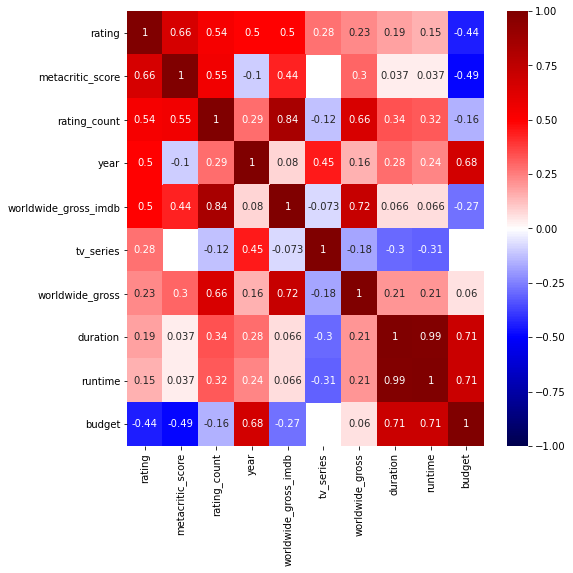

In [53]:
ix = films_df_reordered.iloc[:,:first_cast_column].corr().sort_values('rating', ascending=False).index
films_df_reordered_sorted = films_df_reordered.loc[:, ix]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(films_df_reordered_sorted.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

In [54]:
#sns.heatmap(films_df_reordered.iloc[:,:first_cast_column].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

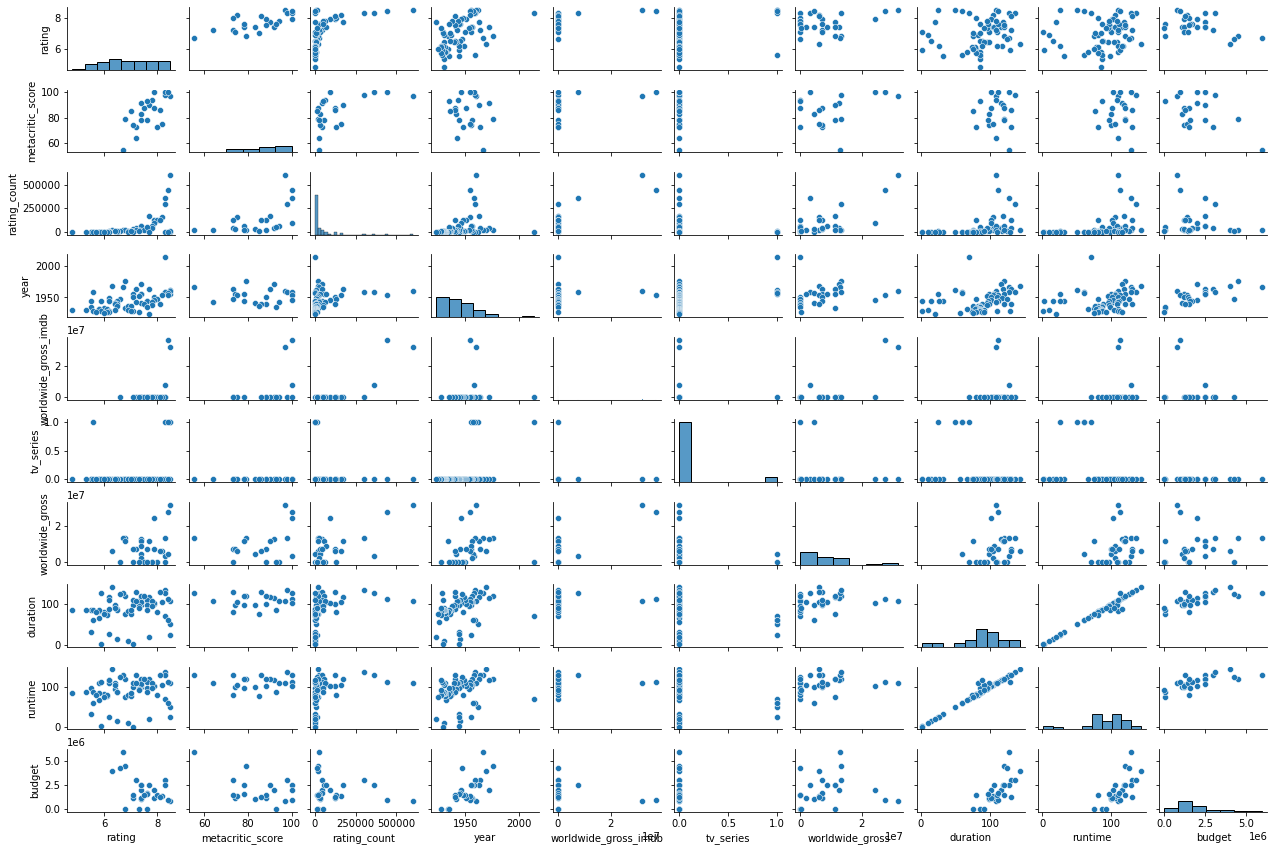

In [55]:
sns.pairplot(films_df_reordered_sorted.iloc[:,:first_cast_column], height=1.2, aspect=1.5);

#### Determine which columns have enough non-null values so they could be used

In [56]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN           38
7000000.0      2
4500000.0      2
11333333.0     2
6000000.0      2
13369740.0     1
549.0          1
8750464.0      1
32000000.0     1
83260.0        1
11436184.0     1
27590734.0     1
47.0           1
12600000.0     1
7008058.0      1
13000000.0     1
3293831.0      1
39776.0        1
51711.0        1
24492698.0     1
6789.0         1
160.0          1
388.0          1
13200000.0     1
4468.0         1
6002370.0      1
2000000.0      1
7020502.0      1
Name: worldwide_gross, dtype: int64

In [57]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,5:15].head(10)


,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
2,4490375.0,13200000.0,NaN,13200000.0,6.8,79.0,20787.0,0.0,0.0,Leonard J. South
3,2000000.0,12600000.0,4121.0,12600000.0,7.4,92.0,41409.0,0.0,0.0,Gilbert Taylor
4,4000000.0,6000000.0,NaN,6000000.0,6.3,NaN,16710.0,0.0,0.0,Jack Hildyard
5,6000000.0,13000000.0,NaN,13000000.0,6.7,55.0,24723.0,0.0,0.0,John F. Warren
6,3000000.0,7008058.0,7095.0,7008058.0,7.2,73.0,45210.0,0.0,0.0,Robert Burks
7,2500000.0,11436184.0,32655.0,11436184.0,7.7,90.0,171527.0,0.0,0.0,Robert Burks
8,NaN,NaN,NaN,NaN,8.5,NaN,3877.0,1.0,0.0,John F. Warren
10,806947.0,32000000.0,32040242.0,32000000.0,8.5,97.0,603067.0,0.0,0.0,John L. Russell
11,NaN,NaN,NaN,NaN,5.6,NaN,127.0,1.0,0.0,John L. Russell
12,3101000.0,13369740.0,73695.0,13369740.0,8.3,98.0,298655.0,0.0,0.0,Robert Burks


In [58]:
first_actor_column = (len(films_to_analyze.columns) - len(dict_of_all_actors))
first_actor_column

15

In [59]:
actor_columns = films_to_analyze.iloc[:, first_actor_column:].columns
actor_columns

Index(['Leo G. Carroll', 'John Longden', 'Edmund Gwenn', 'Gordon Harker',
       'James Stewart', 'Hannah Jones', 'Donald Calthrop', 'Cary Grant',
       'Edward Chapman', 'Basil Radford',
       ...
       'Brigitte Auber', 'Georgette Anys', 'Sara Berner', 'Wendell Corey',
       'Thelma Ritter', 'Raymond Burr', 'Judith Evelyn', 'Ross Bagdasarian',
       'Georgine Darcy', 'Ernest Thesiger'],
      dtype='object', length=633)

In [60]:
films_to_analyze[actor_columns].sum()

Leo G. Carroll      6.0
John Longden        5.0
Edmund Gwenn        4.0
Gordon Harker       4.0
James Stewart       4.0
                   ... 
Raymond Burr        1.0
Judith Evelyn       1.0
Ross Bagdasarian    1.0
Georgine Darcy      1.0
Ernest Thesiger     0.0
Length: 633, dtype: float64

In [61]:
actors_num_of_appearances = films_to_analyze[actor_columns].sum()
actors_num_of_appearances

Leo G. Carroll      6.0
John Longden        5.0
Edmund Gwenn        4.0
Gordon Harker       4.0
James Stewart       4.0
                   ... 
Raymond Burr        1.0
Judith Evelyn       1.0
Ross Bagdasarian    1.0
Georgine Darcy      1.0
Ernest Thesiger     0.0
Length: 633, dtype: float64

In [62]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Leo G. Carroll       True
John Longden         True
Edmund Gwenn         True
Gordon Harker        True
James Stewart        True
                    ...  
Raymond Burr        False
Judith Evelyn       False
Ross Bagdasarian    False
Georgine Darcy      False
Ernest Thesiger     False
Length: 633, dtype: bool

In [63]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 

Index(['Leo G. Carroll', 'John Longden', 'Edmund Gwenn', 'Gordon Harker',
       'James Stewart', 'Hannah Jones', 'Donald Calthrop', 'Cary Grant',
       'Edward Chapman', 'Basil Radford', 'George Curzon', 'Leslie Banks',
       'Grace Kelly', 'Ian Hunter', 'Patricia Hitchcock', 'Isabel Jeans',
       'Ingrid Bergman', 'Percy Marmont'],
      dtype='object')

#### These next few cells are legacy  -----------------------------------------

#### End of legacy code  -----------------------------------------

In [64]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [65]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Leo G. Carroll',
 'John Longden',
 'Edmund Gwenn',
 'Gordon Harker',
 'James Stewart',
 'Hannah Jones',
 'Donald Calthrop',
 'Cary Grant',
 'Edward Chapman',
 'Basil Radford',
 'George Curzon',
 'Leslie Banks',
 'Grace Kelly',
 'Ian Hunter',
 'Patricia Hitchcock',
 'Isabel Jeans',
 'Ingrid Bergman',
 'Percy Marmont']

## Dataset partitioned for analysis

In [66]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [67]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

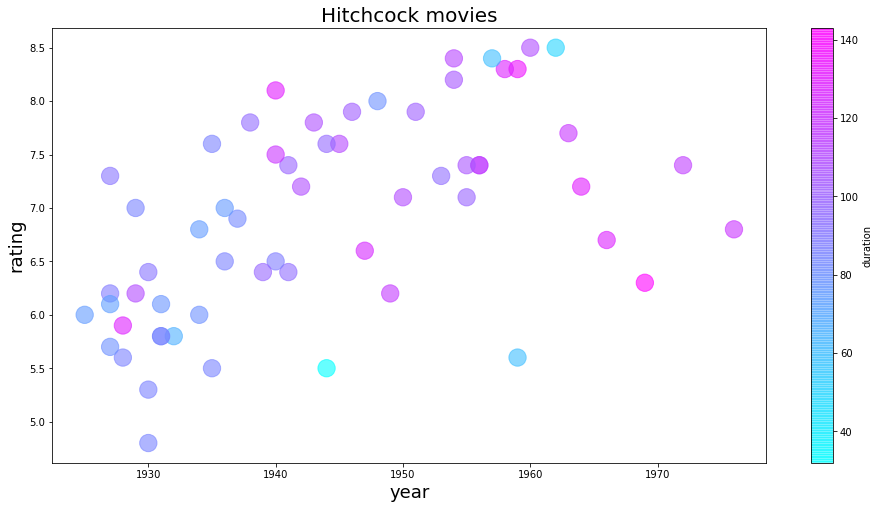

In [68]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'duration'
cm=films_and_features_to_analyze_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

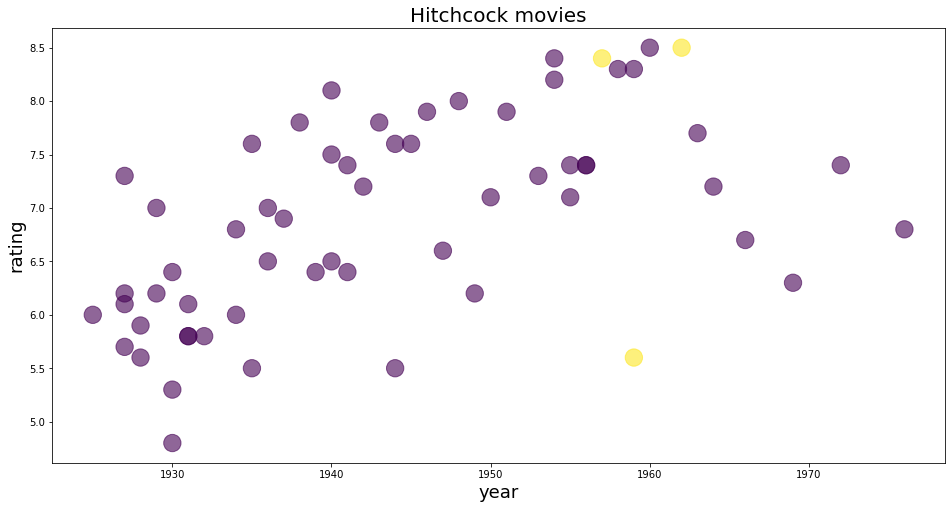

In [69]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [70]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

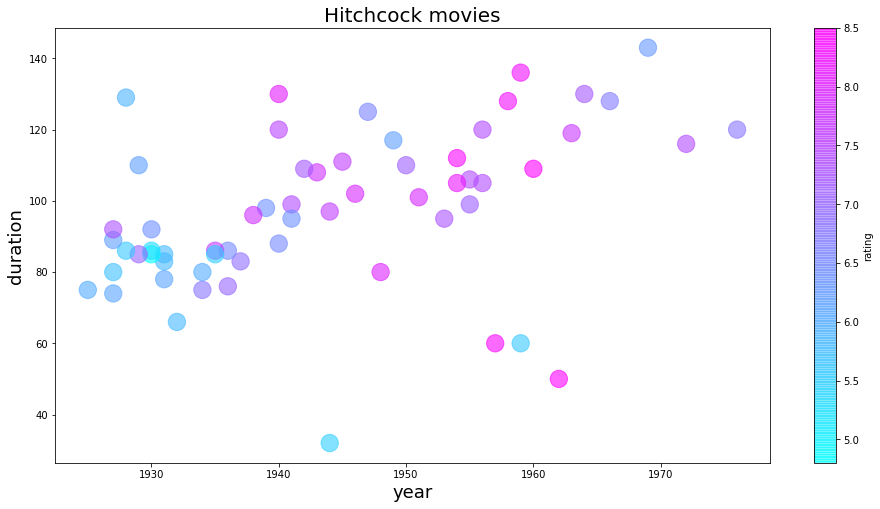

In [71]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating'
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

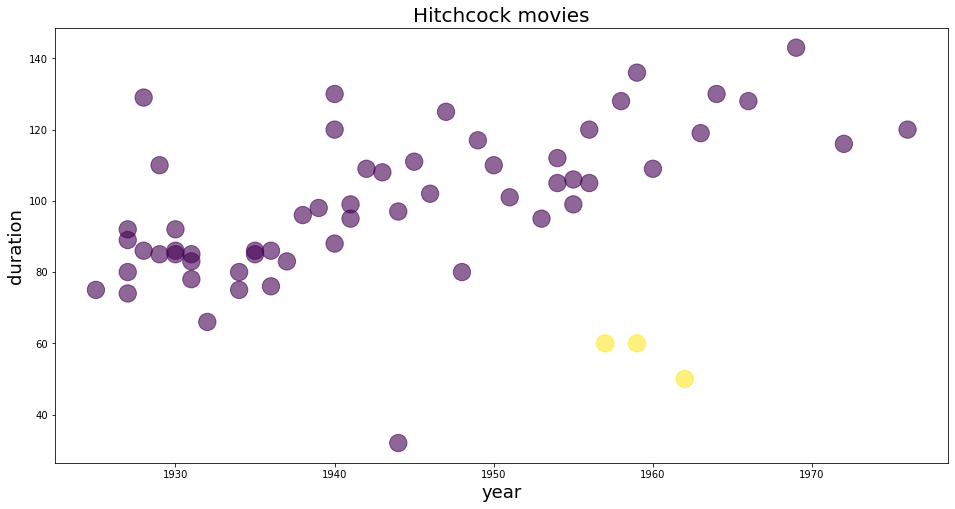

In [72]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


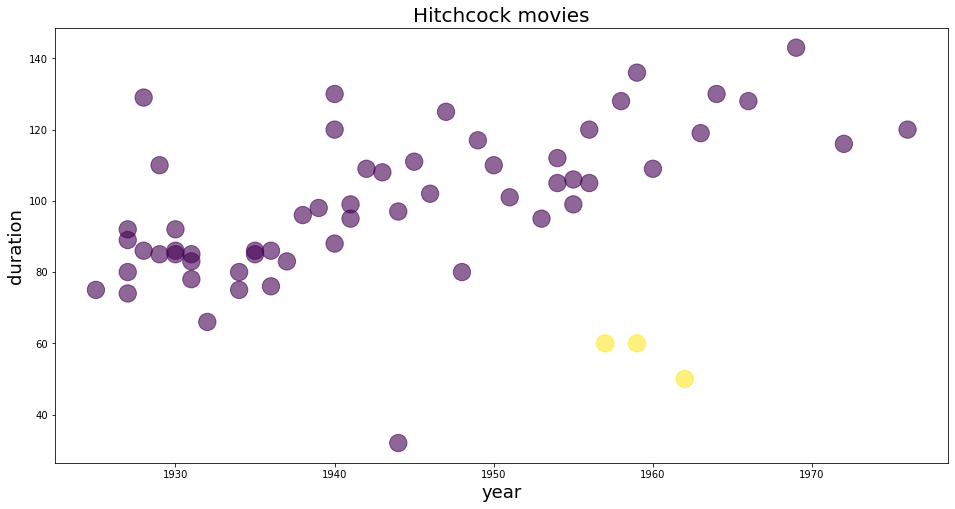

In [73]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


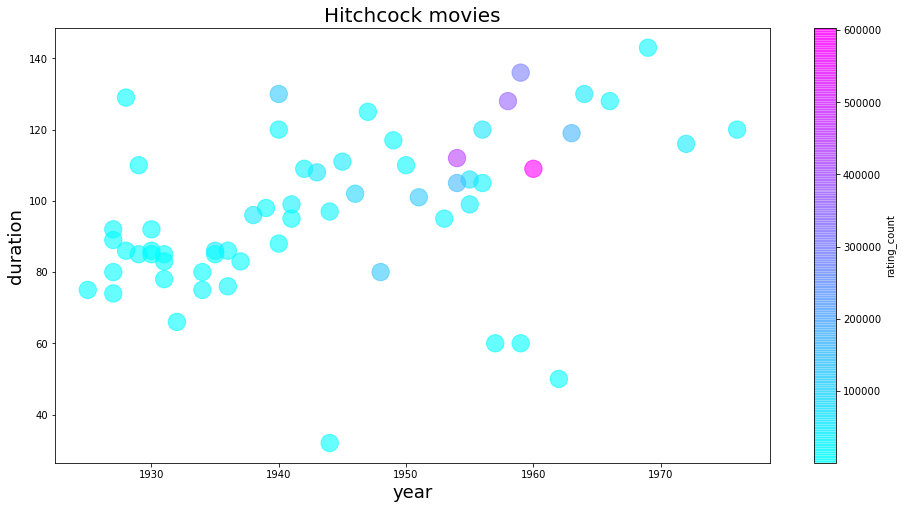

In [74]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cmap=plt.get_cmap("cool")
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )
#plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [75]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

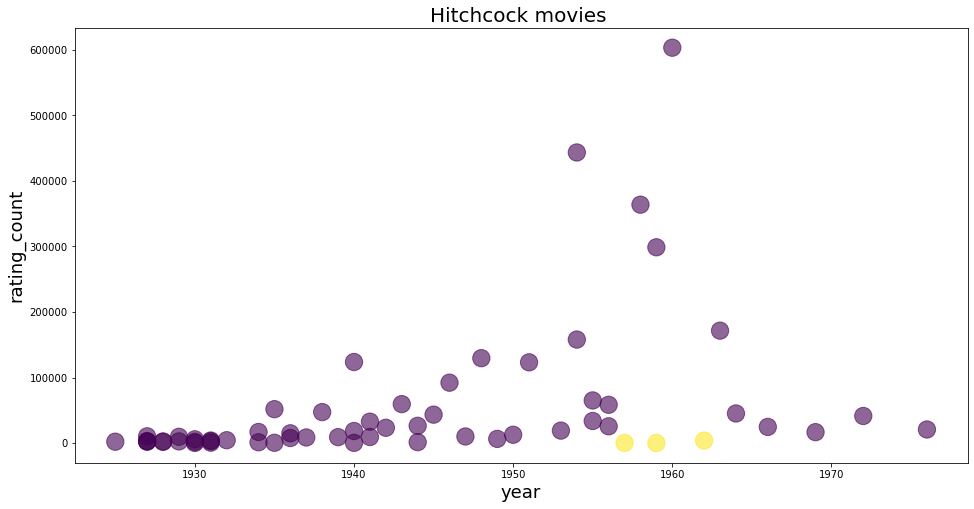

In [76]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


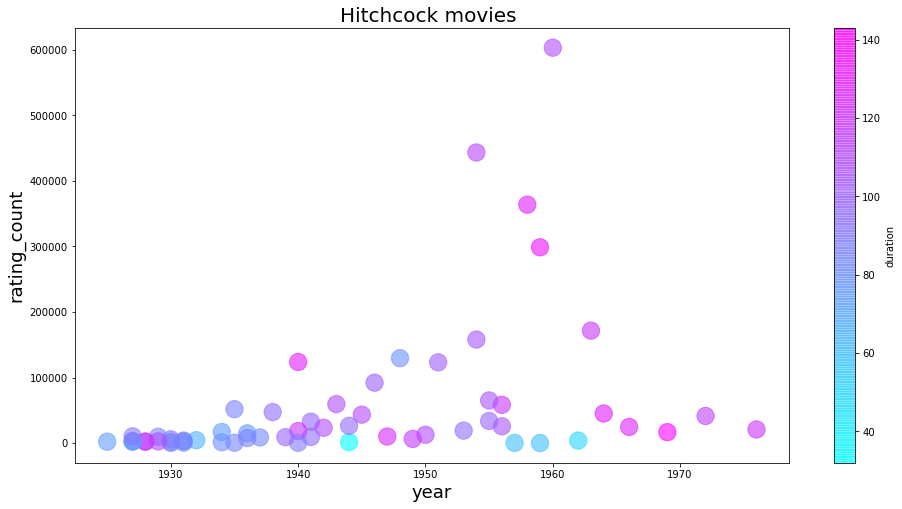

In [77]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[color_dimension ].tolist()
cmap=plt.get_cmap("cool")
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [78]:
#films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1]

In [79]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][x_label]
y_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][y_label]

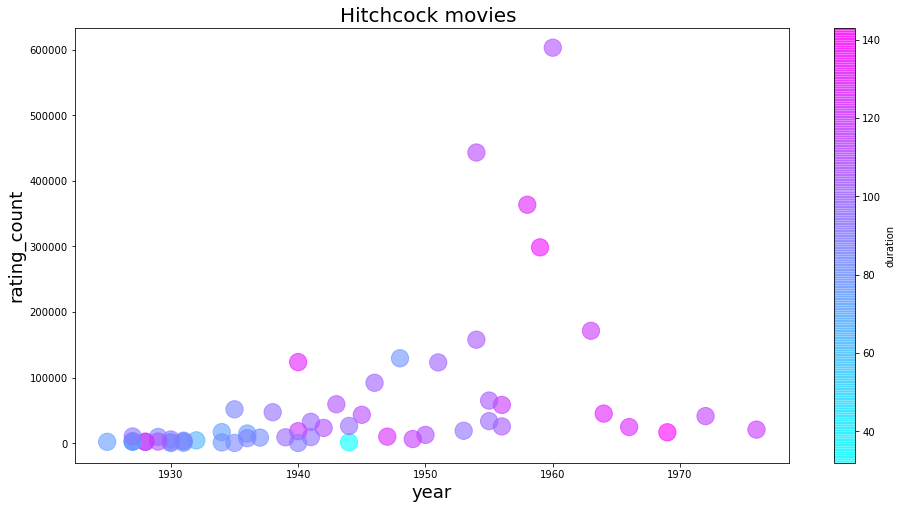

In [80]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][color_dimension ].tolist()
cmap=plt.get_cmap("cool")
#category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [81]:
print( min(x_), max(x_))

1925.0 1976.0


In [82]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [83]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Leo G. Carroll,John Longden,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
8,The Alfred Hitchcock Hour,1962.0,50.0,John F. Warren,0.0,1.0,8.5,3877.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,Startime,1959.0,60.0,John L. Russell,0.0,1.0,5.6,127.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,Suspicion,1957.0,60.0,Ray Rennahan,0.0,1.0,8.4,321.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,Aventure malgache,1944.0,32.0,Günther Krampf,0.0,0.0,5.5,1448.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [84]:
cinematographer = 'Jack E. Cox'

In [85]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


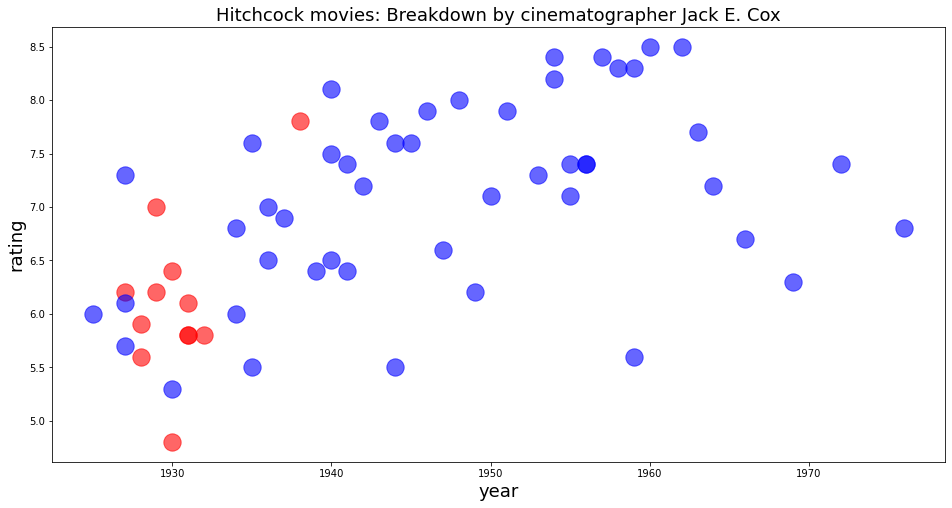

In [86]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [87]:
cinematographer = 'Robert Burks'

In [88]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


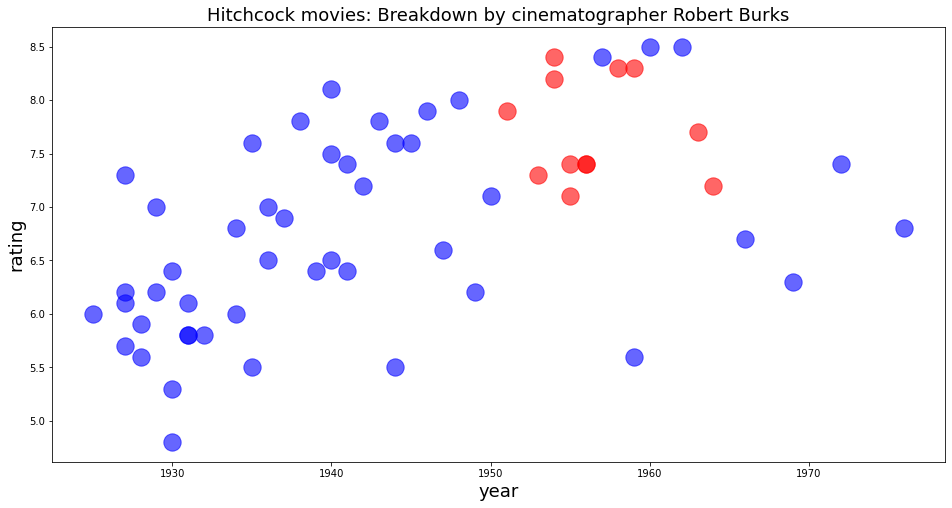

In [89]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [90]:
cinematographer = 'Bernard Knowles'

In [91]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


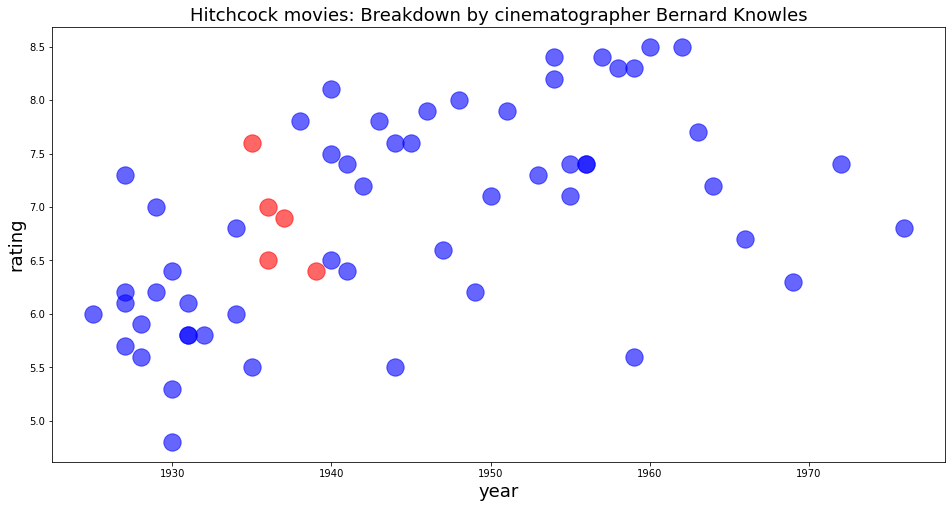

In [92]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

#### Recode misc. cinematographers to `OTHER` to ameliorate issue of not dropping a column and also to increase the chance it will occur in the test set as well

In [93]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [94]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Train Test Split

In [95]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Leo G. Carroll', 'John Longden',
       'Edmund Gwenn', 'Gordon Harker', 'James Stewart', 'Hannah Jones',
       'Donald Calthrop', 'Cary Grant', 'Edward Chapman', 'Basil Radford',
       'George Curzon', 'Leslie Banks', 'Grace Kelly', 'Ian Hunter',
       'Patricia Hitchcock', 'Isabel Jeans', 'Ingrid Bergman',
       'Percy Marmont'],
      dtype='object')

In [96]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [97]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

In [99]:
cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [100]:
#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


In [101]:
columns=ohe.get_feature_names(cat_ohe_vars)

columns

array(['cinematographer_Bernard Knowles',
       'cinematographer_Claude L. McDonnell',
       'cinematographer_Gaetano di Ventimiglia',
       'cinematographer_George Barnes',
       'cinematographer_Harry Stradling Sr.',
       'cinematographer_Jack E. Cox', 'cinematographer_John F. Warren',
       'cinematographer_John L. Russell', 'cinematographer_OTHER',
       'cinematographer_Robert Burks'], dtype=object)

In [102]:
X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Harry Stradling Sr.,cinematographer_Jack E. Cox,cinematographer_John F. Warren,cinematographer_John L. Russell,cinematographer_OTHER,cinematographer_Robert Burks
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Repeating transformations on testing set

In [103]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [104]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head(70)



,year,duration,rating_count
28,1947.0,125.0,10114.0
15,1941.0,99.0,32732.0
25,1950.0,110.0,12768.0
7,1963.0,119.0,171527.0
17,1956.0,120.0,58452.0
33,1944.0,32.0,1448.0
18,1934.0,75.0,16983.0
10,1960.0,109.0,603067.0
45,1936.0,76.0,14937.0
66,1927.0,92.0,10382.0


####  scale the continuous variables in the train set

In [105]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
28,0.269109,1.373683,-0.360724
15,-0.168599,0.219079,-0.172292
25,0.487963,0.707565,-0.338614
7,1.436330,1.107236,0.984019
17,0.925671,1.151644,0.041983


#### select and scale the continuous variables in the test set

In [106]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
12,1959.0,136.0,298655.0
20,1955.0,106.0,65094.0
6,1964.0,130.0,45210.0
42,1939.0,98.0,9119.0
47,1935.0,86.0,51748.0


In [107]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
12,1.144524,1.862170,2.043131
20,0.852719,0.529934,0.097318
6,1.509281,1.595722,-0.068337
42,-0.314501,0.174671,-0.369014
47,-0.606306,-0.358223,-0.013869


### Combine the continuous, categorical, and ohe cat features for our testing set


In [108]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [109]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Harry Stradling Sr.,cinematographer_Jack E. Cox,cinematographer_John F. Warren,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
28,0.269109,1.373683,-0.360724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,-0.168599,0.219079,-0.172292,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25,0.487963,0.707565,-0.338614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.436330,1.107236,0.984019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.925671,1.151644,0.041983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.050255,-2.756248,-0.432921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,-0.679257,-0.846710,-0.303498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10,1.217476,0.663157,4.579209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45,-0.533355,-0.802302,-0.320544,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,-1.189916,-0.091776,-0.358492,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
X_train.shape

(45, 24)

### Combine the continuous and categorical features for our testing set


In [111]:
X_test_cat_df = X_test[cat_columns]

In [112]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [113]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Bernard Knowles,cinematographer_Claude L. McDonnell,cinematographer_Gaetano di Ventimiglia,cinematographer_George Barnes,cinematographer_Harry Stradling Sr.,cinematographer_Jack E. Cox,cinematographer_John F. Warren,...,Edward Chapman,Basil Radford,George Curzon,Leslie Banks,Grace Kelly,Ian Hunter,Patricia Hitchcock,Isabel Jeans,Ingrid Bergman,Percy Marmont
0,1.144524,1.862170,2.043131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.852719,0.529934,0.097318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.509281,1.595722,-0.068337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.314501,0.174671,-0.369014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.606306,-0.358223,-0.013869,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.050255,0.130263,-0.224861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.779768,0.485526,0.870908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,-0.241550,1.595722,0.585577,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.679257,-0.624671,-0.434279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.706817,0.041447,-0.285986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [114]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [115]:
lr.coef_

array([ 9.30050083e-02,  1.47994309e-01,  6.71842746e-01,  6.52039927e-01,
       -2.05306078e-01,  4.25626849e-01,  1.26283214e+00, -1.47625434e-01,
        1.73947156e-01,  3.03536537e-01, -2.41782342e+00, -1.13741244e-02,
       -3.58535460e-02, -6.66133815e-16,  1.96142680e+00, -1.45728065e-02,
       -6.36601962e-01,  7.33389641e-01, -8.79261520e-01,  3.49513088e-01,
        9.94017847e-01, -2.37268366e-01,  1.33903486e+00, -8.43434928e-01,
        7.48314324e-01,  7.60082705e-01, -4.91559278e-01, -9.61167076e-01,
       -2.05306078e-01,  7.51816724e-01, -3.52931512e-01, -3.90119865e-01,
       -6.72614872e-01])

In [116]:
y_pred = lr.predict(X_test_combined)

y_pred

array([9.71841458, 7.24023718, 6.96986944, 8.09266483, 7.20842415,
       6.54798703, 6.40757613, 8.53047372, 6.9611064 , 6.51898634,
       5.33921819, 7.19501576, 6.27117926, 6.79846507, 6.59635685])

In [117]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.95
r2: -0.75


In [118]:
print(r2)

-0.753380935274981


In [119]:
score = lr.score(X_test_combined, y_test) 
score

-0.753380935274981

# Focus on building up from fewer features
for instance the continous ones

### Train Test Split

In [120]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Leo G. Carroll', 'John Longden',
       'Edmund Gwenn', 'Gordon Harker', 'James Stewart', 'Hannah Jones',
       'Donald Calthrop', 'Cary Grant', 'Edward Chapman', 'Basil Radford',
       'George Curzon', 'Leslie Banks', 'Grace Kelly', 'Ian Hunter',
       'Patricia Hitchcock', 'Isabel Jeans', 'Ingrid Bergman',
       'Percy Marmont'],
      dtype='object')

In [121]:
selected_cols = ['year', 'duration', 'rating_count']

In [122]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [124]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
61,1928.0,86.0,2022.0
23,1953.0,95.0,19085.0
8,1962.0,50.0,3877.0
4,1969.0,143.0,16710.0
43,1938.0,96.0,47308.0


####  scale the continuous variables in the train set

In [125]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
61,-1.282425,-0.459763,-0.469098
23,0.643781,-0.052314,-0.314814
8,1.337215,-2.089558,-0.452325
4,1.876553,2.120746,-0.336289
43,-0.511943,-0.007042,-0.059620


#### select and scale the continuous variables in the test set

In [126]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
35,1944.0,97.0,26422.0
64,1927.0,80.0,2523.0
49,1934.0,80.0,1285.0
28,1947.0,125.0,10114.0
52,1931.0,78.0,681.0


In [127]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
35,-0.049653,0.038230,-0.248472
64,-1.359473,-0.731396,-0.464568
49,-0.820136,-0.731396,-0.475762
28,0.181491,1.305848,-0.395930
52,-1.051280,-0.821940,-0.481223


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [128]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,-1.282425,-0.459763,-0.469098
1,0.643781,-0.052314,-0.314814
2,1.337215,-2.089558,-0.452325
3,1.876553,2.120746,-0.336289
4,-0.511943,-0.007042,-0.059620


In [129]:
X_train_combined.shape

(45, 3)

### Combine the continuous and categorical features for our testing set


In [130]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,-0.049653,0.038230,-0.248472
1,-1.359473,-0.731396,-0.464568
2,-0.820136,-0.731396,-0.475762
3,0.181491,1.305848,-0.395930
4,-1.051280,-0.821940,-0.481223
5,-0.666039,-0.459763,-0.417161
6,-1.128329,-0.505035,-0.468700
7,1.029022,1.441664,2.800647
8,2.415890,1.079488,-0.299424
9,0.258540,-0.731396,0.683870


### Now make predictions by instantiating the Linear Regression Model 

In [131]:
#X_train_combined

In [132]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [133]:
lr.coef_

array([0.31065433, 0.03923858, 0.37443009])

In [134]:

y_pred = lr.predict(X_test_combined)

y_pred

array([6.86637287, 6.34835984, 6.51171605, 6.93270599, 6.43431221,
       6.59218741, 6.4275008 , 8.39821895, 7.6540843 , 7.28101243,
       6.45251323, 6.95391654, 6.3366112 , 8.21635848, 6.78448524])

In [135]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.66
r2: 0.55


In [136]:
score = lr.score(X_test_combined, y_test) 
score

0.550615933001503

## Try to fit with just the year

In [137]:
lr = LinearRegression()

In [138]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [139]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [140]:
#X_train_year_only 

In [141]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [142]:
lr.coef_

array([0.44751903])

In [143]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([6.95111253, 6.3649431 , 6.60630698, 7.0545542 , 6.50286532,
       6.67526809, 6.46838476, 7.4338403 , 8.05449029, 7.08903475,
       6.46838476, 7.12351531, 6.3649431 , 7.46832085, 6.81319031])

In [144]:
y_test

35    7.6
64    5.7
49    6.0
28    6.6
52    6.1
46    6.5
55    4.8
13    8.3
2     6.8
27    8.0
54    6.4
26    6.2
65    6.1
12    8.3
39    7.5
Name: rating, dtype: float64

In [145]:
#y_test

In [146]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [147]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.80
r2: 0.33


## Try to fit with just the `year` and `duration`


In [148]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.79
r2: 0.35


## Try to fit with just the `year` and `rating_count`

In [149]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,-1.282425,-0.469098
1,0.643781,-0.314814
2,1.337215,-0.452325
3,1.876553,-0.336289
4,-0.511943,-0.059620
5,0.104443,0.346087
6,0.412636,-0.371932
7,-0.974232,-0.447370
8,-1.513570,-0.467769
9,-1.359473,-0.458853


In [150]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.66
r2: 0.55


## Feature engineer:  log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [151]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [152]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
#X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
61,-1.282425,-0.459763,-0.469098,-1.285834,-0.950190
23,0.643781,-0.052314,-0.314814,0.646349,0.210825
8,1.337215,-2.089558,-0.452325,1.335885,-0.613507
4,1.876553,2.120746,-0.336289,1.870008,0.142092
43,-0.511943,-0.007042,-0.059620,-0.509971,0.680325


In [153]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
35,-0.049653,0.038230,-0.248472,-0.046373,0.379067
64,-1.359473,-0.731396,-0.464568,-1.363641,-0.835702
49,-0.820136,-0.731396,-0.475762,-0.819835,-1.184651
28,0.181491,1.305848,-0.395930,0.184890,-0.117587
52,-1.051280,-0.821940,-0.481223,-1.052653,-1.513047


In [154]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.44
r2: 0.80


In [155]:
lr.coef_

array([-44.13372986,  -0.18083635,   0.05412351,  44.38909429,
         0.5983593 ])

In [198]:
year_min = float(films_and_features_to_analyze_df[['year']].min())
year_min

1925.0

In [199]:
year_max = float(films_and_features_to_analyze_df[['year']].max())

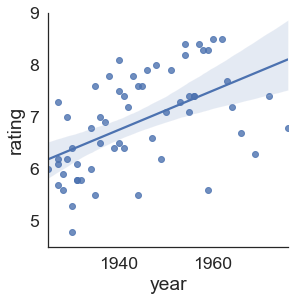

In [203]:
plot_df = films_and_features_to_analyze_df[['year', 'rating']]
sns.set(font_scale=1.6)
sns.set_style("white")
g=sns.lmplot(x='year', y='rating', data=plot_df, 
           fit_reg=True, aspect=1);
g.set(ylim=(4.5, 9))
g.set(xlim=(year_min, year_min+(year_max-year_min)))
g.fig.set_figwidth(4)
g.fig.set_figheight(4)

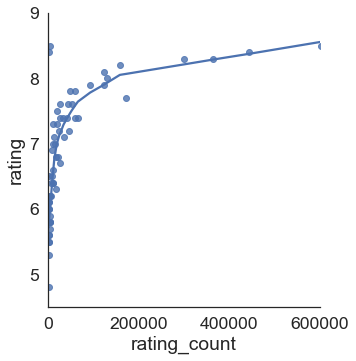

In [171]:
plot_df = films_and_features_to_analyze_df[['rating_count', 'rating']]
g=sns.lmplot(x='rating_count', y='rating', data=plot_df, 
           lowess=True,);
g.set(ylim=(4.5, 9))
g.set(xlim=(0, 600000))

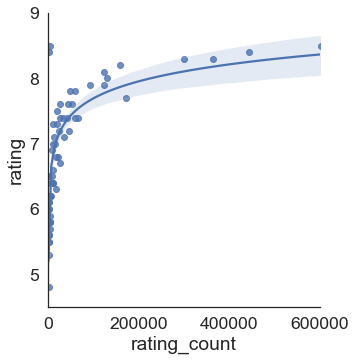

In [170]:
g=sns.lmplot(x='rating_count', y='rating', data=plot_df,
           logx=True,);
g.set(ylim=(4.5, 9))
g.set(xlim=(0, 600000))

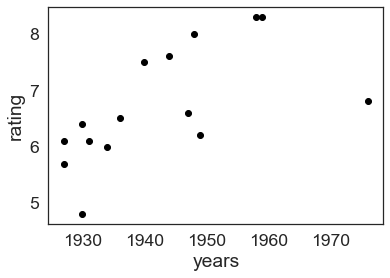

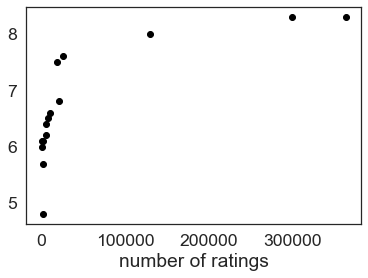

In [159]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to `log_rating_count` and maybe `year`


In [160]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.52
r2: 0.72


In [161]:
films_and_features_to_analyze_df.shape

(60, 26)

## Attempt LassoCV

In [162]:
#X_cols = [*films_and_features_to_analyze_df.columns[1:3],*films_and_features_to_analyze_df.columns[4:6], *films_and_features_to_analyze_df.columns[7:], ]
#X_cols = [*films_and_features_to_analyze_df.columns[1:3],*films_and_features_to_analyze_df.columns[4:6], *films_and_features_to_analyze_df.columns[7:], ]
X_cols = ['year', 'duration', 'rating_count']

#films_and_features_to_analyze_df_copy = copy.deepcopy(films_and_features_to_analyze_df) 

X= films_and_features_to_analyze_df[X_cols]
y= films_and_features_to_analyze_df['rating']

#selected_cols =cont_columns

X['log_year'] = np.log(X.year)
X['log_rating_count'] = np.log(X.rating_count)

# X_test_cont_w_log = copy.deepcopy(X_test_cont) 

# X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
# X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

# X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
# X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

# X= films_and_features_to_analyze_df[X_cols]
# y= films_and_features_to_analyze_df['rating']

<ipython-input-162-ad886dc0e91a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_year'] = np.log(X.year)
<ipython-input-162-ad886dc0e91a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_rating_count'] = np.log(X.rating_count)


In [163]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=9) #10
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=12)#30

#X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=.20, random_state=32)

ss=StandardScaler()

X_train_scaled = ss.fit_transform( X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.fit_transform( X_test )

In [164]:
X.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count'], dtype='object')

In [165]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

model = LassoCV()


In [166]:
poly=PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Degree 2 polynomial regression val R^2: 0.313


In [167]:
lm_poly.coef_

array([ 0.00000000e+00, -1.57531148e+02, -8.77323938e+02, -8.82372760e-01,
       -1.33695872e+00, -2.13504204e+01, -2.42895979e-03, -6.84377451e-02,
       -6.77278003e-05,  1.95547312e+01, -6.90577087e-02, -2.37822925e-04,
        3.64567566e-07,  1.33444362e+02, -1.06912630e-02,  3.32574739e-10,
        1.34197150e-01, -1.75606260e-04, -1.65492844e+01,  2.22156908e+01,
       -8.70539148e-01])

In [168]:
lm_poly.fit(X_,y_)
print(f'Linear Regression test R^2: {lm_poly.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.567


In [169]:
lm_poly.alpha_

AttributeError: 'LinearRegression' object has no attribute 'alpha_'

In [ ]:
model.fit(X_train_scaled,y_train_val)

In [ ]:
model.coef_

In [ ]:
list(zip(X_cols, model.coef_))

In [ ]:
model.score(X_test, y_test)

In [ ]:
model.alpha_

## Repartition data set to analyze `budget` and  `worldwide_gross`

In [ ]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_df_reordered['worldwide_gross'] > 0)]

In [ ]:
first_actor_column = (len(films_to_analyze_financial_df.columns) - len(dict_of_all_actors))
first_actor_column


In [ ]:
actor_columns = films_to_analyze_financial_df.iloc[:, first_actor_column:].columns
actor_columns


In [ ]:
films_to_analyze_financial_df[actor_columns].sum()

In [ ]:
actors_num_of_appearances = analyze_financial_df[actor_columns].sum()
actors_num_of_appearances

In [ ]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

In [ ]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 


In [ ]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'worldwide_gross','cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]
analysis_columns


In [ ]:
films_and_features_to_analyze_financial_df = films_to_analyze_financial_df[analysis_columns]

In [ ]:
films_and_features_to_analyze_financial_df.head(10)

In [ ]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

In [ ]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'budget'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

In [ ]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

In [ ]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

In [ ]:
value_counts = films_and_features_to_analyze_financial_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_financial_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

In [ ]:
selected_cols = [*films_and_features_to_analyze_financial_df.columns[1:8], *films_and_features_to_analyze_financial_df.columns[9:]]

In [ ]:
selected_cols

In [ ]:
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
### Preprocessing

#### Categorical Variable Preprocessing

cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [ ]:


#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


columns=ohe.get_feature_names(cat_ohe_vars)

columns

X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

#### Repeating transformations on testing set

X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

X_train_cont = X_train[['year', 'duration', 'budget','rating_count']]
X_train_cont.head(70)



####  scale the continuous variables in the train set

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


#### select and scale the continuous variables in the test set

X_test_cont = X_test[['year', 'duration', 'budget','rating_count']]
X_test_cont.head()

X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

### Combine the continuous, categorical, and ohe cat features for our testing set


cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

X_train.shape

### Combine the continuous and categorical features for our testing set


X_test_cat_df = X_test[cat_columns]

X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

### Now make predictions by instantiating the Linear Regression Model 

lr = LinearRegression()

lr.fit(X_train_combined, y_train)

lr.coef_

y_pred = lr.predict(X_test_combined)

y_pred

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

print(r2)

score = lr.score(X_test_combined, y_test) 
score

### Look at continous variable including `budget`

In [ ]:
films_and_features_to_analyze_financial_df.columns

selected_cols = ['budget', 'rating_count']
#selected_cols = ['year', 'duration', 'budget', 'rating_count']
#selected_cols = ['budget']
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train.columns

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_train_scaled

In [ ]:
cont_columns = X_train.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

In [ ]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

In [ ]:
#X_test = X_test[['year', 'budget','rating_count']]

X_test = X_test[selected_cols]
X_test.head()

X_test_scaled = ss.transform(X_test)

cont_columns = X_test.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test.index)

X_test_scaled_df.head()

In [ ]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

In [ ]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

lr.coef_

In [ ]:
y_pred = lr.predict(X_test_combined)

y_pred

In [ ]:

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

In [ ]:
X_train_combined.head()

In [ ]:
X_train_cont

## include `log(year)` `budget^2` and `log(rating_count)`

In [ ]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

#X_train_cont_w_log['log_budget'] = np.log(X_train_cont_w_log.budget)
#X_test_cont_w_log['log_budget'] = np.log(X_test_cont_w_log.budget)
X_train_cont_w_log['pow_budget'] = X_train_cont_w_log.budget**2
X_test_cont_w_log['pow_budget'] =  X_test_cont_w_log.budget**2


X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)


In [ ]:
# films_and_features_to_analyze_financial_df.columns

#selected_cols = [ 'log_year', 'log_budget', 'log_rating_count']
selected_cols = ['year','budget', 'rating_count', 'log_year', 'pow_budget', 'log_rating_count']
# #selected_cols = ['year', 'duration', 'budget', 'rating_count']
# #selected_cols = ['budget']
# X= films_and_features_to_analyze_financial_df[selected_cols]
# y= films_and_features_to_analyze_financial_df['rating']

X_train_cont_w_log = X_train_cont_w_log[ selected_cols ]
X_test_cont_w_log  = X_test_cont_w_log[ selected_cols ]

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# X_train.columns

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)
X_train_scaled.shape

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)
X_train_scaled_df.head()

X_test_scaled_df = ss.transform(X_test_cont_w_log)

In [ ]:
X_test_scaled_df

In [ ]:
cont_columns = X_test_cont_w_log.columns
cont_columns

In [ ]:
X_test_scaled_df

In [ ]:
cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled_df, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled)


In [ ]:
# X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

# X_train_combined.head()


# X_test_cont = X_test[['year','budget', 'rating_count', 'log_year', 'log_budget', 'log_rating_count']]
# X_test_cont.head()




X_test_scaled_df.head()

# X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

# X_test_combined

lr = LinearRegression()

lr.fit(X_train_scaled_df,y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred



from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

X_train_scaled_df.head()